<a href="https://colab.research.google.com/github/AmiBuch/exp-forecasting-methods-personal/blob/main/scripts/airPassengers_pe_wpe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from numpy import array
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# Load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
air_passengers = pd.read_csv(url, index_col='Month', parse_dates=True)

# Convert the 'Passengers' column to a numpy array
raw_seq = air_passengers['Passengers'].values



In [ ]:
# Choose a number of time steps
n_steps = 48
# Split into samples
X, y = split_sequence(raw_seq[:-12], n_steps)

class MLP(nn.Module):
    def __init__(self, input_size=48, hidden_size=200, output_size=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Instantiate the model
model = MLP()

# Convert to PyTorch tensors and create a DataLoader
inputs = torch.from_numpy(np.array(X)).float()
targets = torch.from_numpy(np.array(y)).float()
dataset = TensorDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=12)

# Define a loss function and an optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

# Training loop
for epoch in range(3000):
    for inputs, targets in dataloader:
        outputs = model(inputs)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Predict future values



Epoch 100, Loss: 98.54663848876953
Epoch 200, Loss: 103.4924545288086
Epoch 300, Loss: 97.38919830322266
Epoch 400, Loss: 91.10363006591797
Epoch 500, Loss: 86.8029556274414
Epoch 600, Loss: 98.46347045898438
Epoch 700, Loss: 56.521514892578125
Epoch 800, Loss: 91.97025299072266
Epoch 900, Loss: 132.07664489746094
Epoch 1000, Loss: 71.09244537353516
Epoch 1100, Loss: 61.63442611694336
Epoch 1200, Loss: 59.22053146362305
Epoch 1300, Loss: 71.72674560546875
Epoch 1400, Loss: 102.6019287109375
Epoch 1500, Loss: 21.70764923095703
Epoch 1600, Loss: 67.80967712402344
Epoch 1700, Loss: 31.28011131286621
Epoch 1800, Loss: 39.02932357788086
Epoch 1900, Loss: 45.22564697265625
Epoch 2000, Loss: 53.51687240600586
Epoch 2100, Loss: 56.91423034667969
Epoch 2200, Loss: 31.126901626586914
Epoch 2300, Loss: 46.327335357666016
Epoch 2400, Loss: 56.51079177856445
Epoch 2500, Loss: 53.306243896484375
Epoch 2600, Loss: 51.3646354675293
Epoch 2700, Loss: 44.879581451416016
Epoch 2800, Loss: 50.072681427001

In [ ]:
outputhours = 12
start_idx = 83
final_pred = []
yhat = raw_seq[131]
for part_start in range(83, 95):
    x_input = np.array(raw_seq[part_start:part_start+48])
    x_input[47] = yhat
    x_input = torch.from_numpy(np.array(x_input)).float()
    yhat = model(x_input).item()
    final_pred.append(yhat)

print("Predicted values: ")
print(final_pred)

actual_values = raw_seq[start_idx+48:start_idx+48+outputhours]
print("Actual values: ")
print(actual_values)

# Calculate MAE
mae = np.mean(np.abs(final_pred - actual_values))
print(f"MAE: {mae}")

# Calculate R^2
r2 = r2_score(actual_values, final_pred)
print(f"R^2: {r2}")
mean_actual = np.mean(actual_values)
print(f"Mean of actual values: {mean_actual}")


Predicted values: 
[357.6023254394531, 381.13067626953125, 351.8033142089844, 385.6043395996094, 364.6141052246094, 345.6220397949219, 388.8039245605469, 452.8944396972656, 450.8377380371094, 380.14837646484375, 358.169189453125, 339.2191467285156]
Actual values: 
[405 417 391 419 461 472 535 622 606 508 461 390]
MAE: 94.21253204345703
R^2: -0.9415595152531404
Mean of actual values: 473.9166666666667


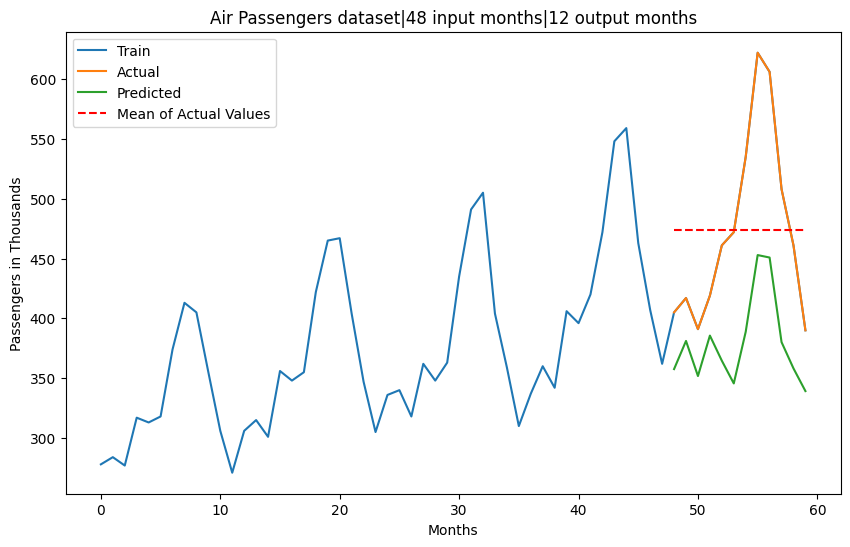

In [ ]:
# Plotting the results
inputhours = 48
plt.figure(figsize=(10, 6))
plt.plot(range(outputhours + 48), raw_seq[start_idx:start_idx+60], label = 'Train')
plt.plot(range(48, 48+outputhours), actual_values, label='Actual')
plt.plot(range(48, 48+outputhours), final_pred, label='Predicted')
plt.plot(range(input_hours, input_hours + output_hours), [mean_actual]*output_hours, 'r--', label='Mean of Actual Values')
plt.title('Air Passengers dataset|48 input months|12 output months')
plt.xlabel('Months')
plt.ylabel('Passengers in Thousands')
plt.legend()
plt.show()

In [ ]:
def get_positional_encoding(seq_len, d_model):
    pe = np.zeros((seq_len, d_model))
    position = np.arange(0, seq_len).reshape(-1, 1)
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return torch.tensor(pe, dtype=torch.float32)

# Example usage:
seq_len = 48  # Length of the input sequence
d_model = 1  # Dimension of each data point (assuming a single feature per timestamp)
positional_encoding = get_positional_encoding(seq_len, d_model)
# Model definition
class MLPWithPositionalEncoding(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, seq_len):
        super(MLPWithPositionalEncoding, self).__init__()
        self.seq_len = seq_len
        self.d_model = input_size // seq_len

        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        self.relu = torch.nn.ReLU()

        # Positional encoding
        self.positional_encoding = get_positional_encoding(seq_len, self.d_model)

    def forward(self, x):
        # Reshape x to (batch_size, seq_len, d_model) if necessary
        batch_size = x.shape[0]
        x = x.view(batch_size, self.seq_len, self.d_model)

        # Apply positional encoding
        x = x + self.positional_encoding

        # Flatten the input again
        x = x.view(batch_size, -1)

        # Pass through MLP layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x



In [ ]:
# Instantiate the model
input_size = 48  # Number of input data points
hidden_size = 100  # Size of hidden layer
output_size = 1  # Single output value
seq_len = 48  # Length of input sequence

model = MLPWithPositionalEncoding(input_size, hidden_size, output_size, seq_len)

# Define a loss function and an optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


inputs = torch.from_numpy(X).float()
targets = torch.from_numpy(y).float()
dataset = TensorDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=12)

# Training loop
for epoch in range(3000):
    for inputs, targets in dataloader:
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 100, Loss: 54.349029541015625
Epoch 200, Loss: 53.797607421875
Epoch 300, Loss: 53.18765640258789
Epoch 400, Loss: 52.45920181274414
Epoch 500, Loss: 51.77989196777344
Epoch 600, Loss: 51.56403732299805
Epoch 700, Loss: 51.38190841674805
Epoch 800, Loss: 51.10261535644531
Epoch 900, Loss: 50.92066192626953
Epoch 1000, Loss: 50.76102066040039
Epoch 1100, Loss: 50.67605209350586
Epoch 1200, Loss: 50.6738395690918
Epoch 1300, Loss: 50.634559631347656
Epoch 1400, Loss: 50.62295913696289
Epoch 1500, Loss: 50.55948257446289
Epoch 1600, Loss: 50.50265884399414
Epoch 1700, Loss: 50.49766159057617
Epoch 1800, Loss: 50.468963623046875
Epoch 1900, Loss: 50.45879364013672
Epoch 2000, Loss: 50.47631072998047
Epoch 2100, Loss: 50.48561096191406
Epoch 2200, Loss: 50.47369384765625
Epoch 2300, Loss: 50.45785903930664
Epoch 2400, Loss: 50.457374572753906
Epoch 2500, Loss: 50.46121597290039
Epoch 2600, Loss: 50.435333251953125
Epoch 2700, Loss: 50.41154479980469
Epoch 2800, Loss: 50.46429443359375

In [ ]:
# Prediction
input_hours = 48
output_hours = 12
start_idx = 83
final_pred = []

for i in range(output_hours):
    x_input = raw_seq[start_idx+i:start_idx+input_hours+i]

    x_input = torch.from_numpy(np.array(x_input)).float()
    yhat = model(x_input.unsqueeze(0)).item()
    final_pred.append(yhat)

print("Predicted values:")
print(final_pred)
print("Actual values:")
actual_values = raw_seq[start_idx+input_hours:start_idx+input_hours+output_hours]
print(actual_values)

# Calculate MAE
mae = np.mean(np.abs(np.array(final_pred) - actual_values))
print(f"MAE: {mae}")

# Calculate R^2
r2 = r2_score(actual_values, final_pred)
print(f"R^2: {r2}")

mean_actual = np.mean(actual_values)
print(f"Mean of actual values: {mean_actual}")

Predicted values:
[405.3308410644531, 463.2952575683594, 471.0274353027344, 466.32720947265625, 463.2273254394531, 463.0041198730469, 468.596435546875, 463.0959167480469, 457.5260314941406, 454.0863342285156, 441.2204895019531, 442.9519348144531]
Actual values:
[405 417 391 419 461 472 535 622 606 508 461 390]
MAE: 57.1358896891276
R^2: 0.01218426214648638
Mean of actual values: 473.9166666666667


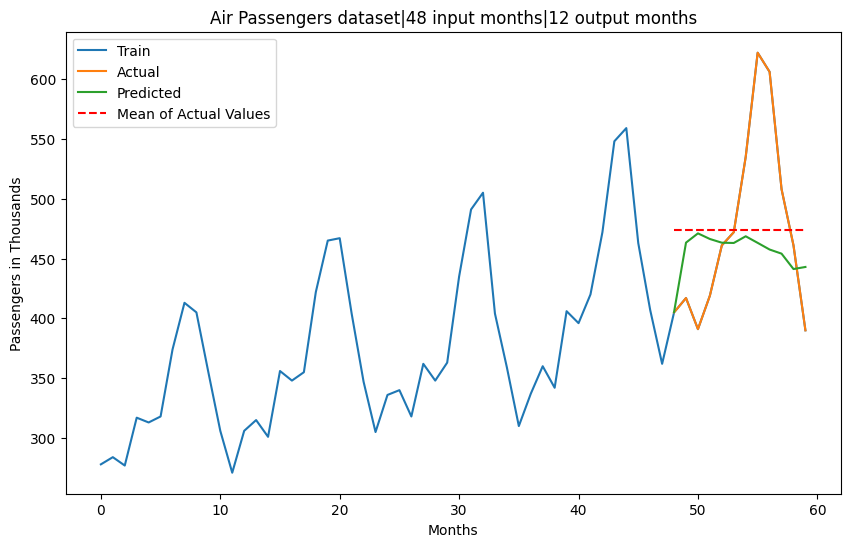

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(outputhours + 48), raw_seq[start_idx:start_idx+60], label = 'Train')
plt.plot(range(48, 48+outputhours), actual_values, label='Actual')
plt.plot(range(48, 48+outputhours), final_pred, label='Predicted')
plt.plot(range(input_hours, input_hours + output_hours), [mean_actual]*output_hours, 'r--', label='Mean of Actual Values')
plt.title('Air Passengers dataset|48 input months|12 output months')
plt.xlabel('Months')
plt.ylabel('Passengers in Thousands')
plt.legend()
plt.show()